In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from frt_distributions import AnalyticalDistribution, calc_distance, generate_embedding, mean_variance_embedding, earth_movers_distance, hausdorff_distance, hungarian_matching 
from visualisations import highlight_node_and_neighbors, VisualiseEmbedding, visualise_matching, find_orbits

In [4]:

def generate_noisy_networks(ground_truth, alpha, beta, num_graphs):
    """
    Generates noisy networks from a ground truth graph.
    
    Parameters:
    - ground_truth (networkx.Graph): Ground truth graph.
    - alpha (float): False positive rate (probability of adding a non-existent edge).
    - beta (float): False negative rate (probability of removing an existing edge).
    - num_graphs (int): Number of noisy networks to generate.
    
    Returns:
    - list of networkx.Graph: List of noisy graphs.
    """
    # Get the list of all nodes
    nodes = list(ground_truth.nodes)
    num_nodes = len(nodes)
    
    # Generate the adjacency matrix for the ground truth
    ground_truth_adj = nx.to_numpy_array(ground_truth)
    
    # Mask for existing edges and non-edges
    existing_edges = ground_truth_adj
    non_edges = 1 - existing_edges
    
    # Generate noisy graphs
    noisy_graphs = []
    for _ in range(num_graphs):
        # Random matrices for false positive and false negative decisions
        fp_random = np.random.rand(num_nodes, num_nodes)
        fn_random = np.random.rand(num_nodes, num_nodes)
        
        # Apply noise
        noisy_adj = (existing_edges * (fn_random > beta)) + (non_edges * (fp_random <= alpha))
        
        # Ensure symmetry for undirected graphs
        noisy_adj = np.maximum(noisy_adj, noisy_adj.T)
        
        # Remove self-loops
        np.fill_diagonal(noisy_adj, 0)
        
        # Create a new NetworkX graph from the noisy adjacency matrix
        noisy_graph = nx.from_numpy_array(noisy_adj)
        noisy_graphs.append(noisy_graph)
    
    return noisy_graphs



def generate_noisy_networks_2(graph, tpr, fpr, num_graphs=1):
    """
    Generates noisy versions of a ground truth graph using true positive rate (TPR)
    and false positive rate (FPR).

    Parameters:
    - graph (nx.Graph): Input NetworkX graph (ground truth).
    - tpr (float): True positive rate (fraction of true edges retained).
    - fpr (float): False positive rate (fraction of non-edges added).
    - num_graphs (int): Number of noisy graphs to generate.

    Returns:
    - List of noisy NetworkX graphs.
    """
    # Get the set of all possible edges and existing edges
    nodes = list(graph.nodes)
    n = len(nodes)
    edges = set(graph.edges)
    all_possible_edges = {(u, v) for u in nodes for v in nodes if u < v}
    non_edges = all_possible_edges - edges

    # Convert edge sets to arrays for efficient computation
    existing_edges = np.array(list(edges))
    non_edges = np.array(list(non_edges))

    noisy_graphs = []

    for _ in range(num_graphs):
        # Generate random values for true positives and false positives
        tp_random = np.random.rand(len(existing_edges))
        fp_random = np.random.rand(len(non_edges))

        # Retain existing edges with probability tpr (true positives)
        keep_edges = existing_edges[tp_random <= tpr]

        # Add non-edges with probability fpr (false positives)
        add_edges = non_edges[fp_random <= fpr]

        # Create a new noisy graph
        noisy_graph = nx.Graph()
        noisy_graph.add_nodes_from(nodes)
        noisy_graph.add_edges_from(keep_edges)
        noisy_graph.add_edges_from(add_edges)

        noisy_graphs.append(noisy_graph)

    return noisy_graphs



def draw_graph_with_highlight(graph, highlight_edge, pos):
    """
    Draws a NetworkX graph and highlights a specific edge in a different color.

    Parameters:
    - graph: NetworkX graph
    - highlight_edge: Tuple representing the edge to be highlighted (u, v)
    """

    # Draw the main graph
    nx.draw(graph, pos, with_labels=True, edge_color="black", node_color="lightblue", node_size=500)

    # Highlight the specified edge
    if graph.has_edge(*highlight_edge):
        nx.draw_networkx_edges(
            graph, pos, edgelist=[highlight_edge], edge_color="red", width=2.5
        )
    else:
        # If the edge isn't in the graph, draw it as a dashed red line
        nx.draw_networkx_edges(
            graph, pos, edgelist=[highlight_edge], edge_color="red", style="dashed", width=2.5
        )

    plt.show()

In [5]:
G_0 = nx.karate_club_graph()
for u, v in G_0.edges:
    G_0[u][v].clear()
#alpha = 0.005 ; beta = 0.3
#tpr = 0. ; fpr = 0.1
#G= generate_noisy_networks(G_0, alpha, beta, 1)[0]
#G = generate_noisy_networks(G_0, tpr, fpr, 1)[0]

In [6]:
pos = nx.spring_layout(G_0)

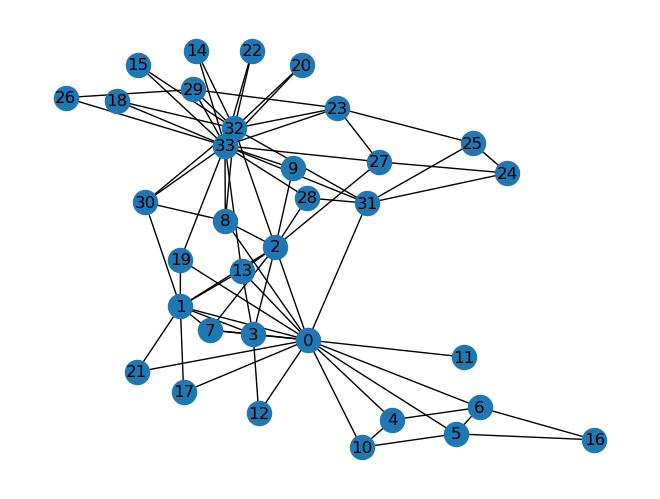

In [11]:
nx.draw(G_0, with_labels=True, pos=pos)

In [35]:
from itertools import product

def calculate_embedding_distances(G_0, noisy_graphs, embedding_function, distance_function, embedding_G0=None):
    """
    Calculate the average distance between the embeddings of the ground truth graph and noisy graphs.
    
    Parameters:
        G_0 (networkx.Graph): The ground truth graph.
        noisy_graphs (list[networkx.Graph]): A list of noisy graphs.
        embedding_function (callable): Function to compute node embeddings.
        distance_function (callable): Function to compute distance between two embeddings.
        
    Returns:
        float: The average distance between embeddings.
    """
    # Compute the embedding for the ground truth graph
    if embedding_G0 is None:
        embedding_G0 = embedding_function(G_0, M=100, progress_bar=False)
    
    # Compute distances for noisy graphs
    distances = []
    for G in noisy_graphs:
        embedding_G = embedding_function(G, M=100, progress_bar=False)
        distance = distance_function(embedding_G0, embedding_G)
        distances.append(distance)
    
    return np.mean(distances)


def evaluate_embedding_quality(G_0, embedding_function, distance_function, n_graphs=10, steps=10, embedding_G0=None):
    """
    Evaluate the quality of embeddings by generating noisy graphs and computing average distances.
    
    Parameters:
        G_0 (networkx.Graph): The ground truth graph.
        embedding_function (callable): Function to compute node embeddings.
        distance_function (callable): Function to compute distance between two embeddings.
        n_graphs (int): Number of noisy graphs to generate for each (alpha, beta) pair.
        steps (int): Number of steps to divide the range of alpha and beta.
        
    Returns:
        dict: A dictionary with (alpha, beta) as keys and average distances as values.
    """
    results = {}
    alphas = np.linspace(0, 0.1, steps)
    betas = np.linspace(0, 1, steps)
    
    for alpha, beta in tqdm(product(alphas, betas), total=steps * steps):
        noisy_graphs = generate_noisy_networks(G_0, alpha, beta, n_graphs)
        avg_distance = calculate_embedding_distances(G_0, noisy_graphs, embedding_function, distance_function, embedding_G0)
        results[(alpha, beta)] = avg_distance
    
    return results

def results_to_array(results, steps):
    """
    Convert the results dictionary into a 2D NumPy array for visualization.
    
    Parameters:
        results (dict): A dictionary with keys as (alpha, beta) tuples and values as average distances.
        steps (int): Number of steps in the alpha and beta ranges.
        
    Returns:
        np.ndarray: A 2D array where rows correspond to beta and columns to alpha.
    """
    # Initialize a 2D array with NaN to signify missing values
    array = np.full((steps, steps), np.nan)
    
    # Generate alpha and beta values in the range [0, 1] with the given number of steps
    alpha_values = np.linspace(0, 0.1, steps)
    beta_values = np.linspace(0, 1, steps)
    
    # Populate the array with valid results
    for i, alpha in enumerate(alpha_values):
        for j, beta in enumerate(beta_values):
            # Directly map alpha, beta to array indices
            if (alpha, beta) in results:
                array[j, i] = results[(alpha, beta)]  # Rows correspond to beta, columns to alpha

    return array

In [37]:
results = evaluate_embedding_quality(G_0, generate_embedding, earth_movers_distance, n_graphs=20, steps=10, embedding_G0 = generate_embedding(G_0, M=100, progress_bar=False))

100%|█████████████████████████████████████████| 100/100 [03:36<00:00,  2.16s/it]


In [45]:
results_arr1 = results_to_array(results, steps=10)

Text(0.5, 1.0, 'Earth-movers distance')

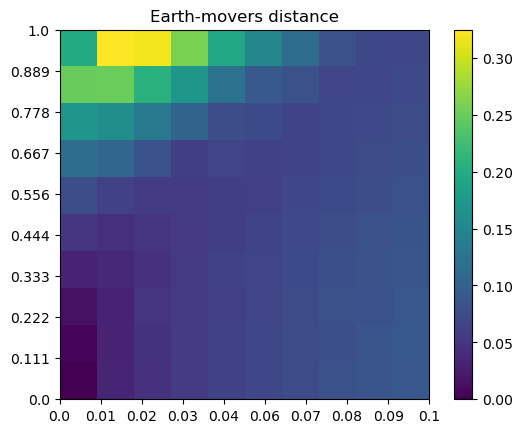

In [47]:
plt.imshow(results_arr, origin='lower', extent=(0, 1, 0, 1))
plt.xticks(np.linspace(0, 1, 10), np.round(np.linspace(0, 0.1, 10), 2)) ; plt.yticks(np.linspace(0, 1, 10), np.round(np.linspace(0, 1, 10), 3))
plt.colorbar()
plt.title('Earth-movers distance')

In [49]:
results2 = evaluate_embedding_quality(G_0, generate_embedding, hausdorff_distance, n_graphs=20, steps=10, embedding_G0 = generate_embedding(G_0, M=100, progress_bar=False))

  2%|▊                                          | 2/100 [00:04<03:49,  2.34s/it]/Users/vedantat/Desktop/DPhil Codes/frt_distributions.py:62: RuntimeWarning: divide by zero encountered in divide
  T = sp.diags(1 / D) @ A
100%|█████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


In [55]:
results_arr2 = results_to_array(results2, steps=10)

Text(0.5, 1.0, 'Hausdorff distance')

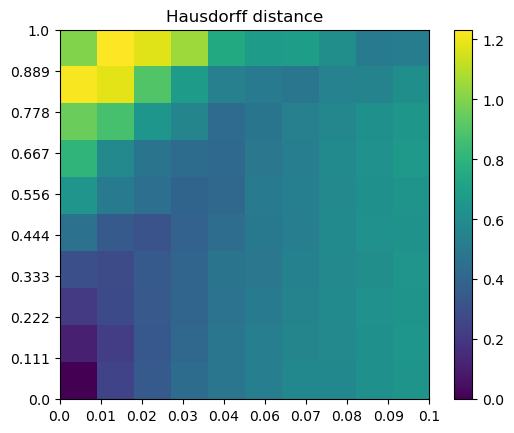

In [57]:
plt.imshow(results_arr2, origin='lower', extent=(0, 1, 0, 1))
plt.xticks(np.linspace(0, 1, 10), np.round(np.linspace(0, 0.1, 10), 2)) ; plt.yticks(np.linspace(0, 1, 10), np.round(np.linspace(0, 1, 10), 3))
plt.colorbar()
plt.title('Hausdorff distance')